# US-009: Análisis de Series Temporales

**Objetivo**: Realizar análisis exhaustivo de series temporales en el dataset de consumo energético industrial.

**Alcance**:
- Descomposición STL (Seasonal-Trend-Loess) por tipo de carga
- Análisis ACF/PACF para identificación de autocorrelación
- Detección y cuantificación de patrones estacionales
- Generación de visualizaciones estáticas (Matplotlib/Seaborn)

**Dataset**: Steel Industry Energy Consumption (UCI ML Repository)

**Autor**: MLOps Team - Proyecto Atreides  
**Fecha**: 2025-01-17

## 1. Setup y Configuración

Importación de librerías y configuración del entorno de análisis.

In [1]:
# Librerías estándar
import warnings
from pathlib import Path
import logging

# Data manipulation
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom utilities
from src.utils.time_series import (
    perform_stl_decomposition,
    plot_stl_components,
    calculate_acf_pacf,
    plot_acf_pacf,
    analyze_seasonality_by_group,
    plot_seasonality_comparison,
    extract_seasonal_pattern,
    plot_seasonal_pattern
)

# Configuración
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Matplotlib configuration
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")

# Paths
PROJECT_ROOT = Path.cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "steel_cleaned.parquet"
FIGURES_PATH = PROJECT_ROOT / "reports" / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Figures path: {FIGURES_PATH}")

Project root: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides
Data path: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\data\processed\steel_cleaned.parquet
Figures path: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures


## 2. Carga de Datos

Extracción del dataset desde DuckDB con enfoque en variables temporales.

In [2]:
# Cargar datos desde Parquet (ya limpiados por clean_data.py)
df = pl.read_parquet(DATA_PATH)

# Seleccionar columnas relevantes para análisis temporal
df = df.select([
    'date',
    'Usage_kWh',
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM',
    'WeekStatus',
    'Day_of_week',
    'Load_Type'
])

# Convertir 'date' a datetime
# Formato en parquet: " DD/MM/YYYY HH:MM " (con espacios)
df = df.with_columns(
    pl.col('date')
    .str.strip_chars()  # Quitar espacios
    .str.strptime(pl.Datetime, "%d/%m/%Y %H:%M")
    .alias('date')
)

# Ordenar por fecha
df = df.sort('date')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Date dtype: {df['date'].dtype}")
print(f"\nLoad Types: {df['Load_Type'].unique().sort().to_list()}")
print(f"Week Status: {df['WeekStatus'].unique().sort().to_list()}")
print(f"\nFirst rows:")
df.head()

Dataset shape: (34910, 11)
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:45:00
Date dtype: Datetime(time_unit='us', time_zone=None)

Load Types: ['Light_Load', 'Maximum_Load', 'Medium_Load']
Week Status: ['Weekday', 'Weekend']

First rows:


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
datetime[μs],f64,f64,f64,f64,f64,f64,i64,str,str,str
2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.3,100.0,0,"""Weekday""","""Monday""","""Light_Load"""
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,"""Weekday""","""Monday""","""Light_Load"""
2018-01-01 00:30:00,4.0,4.46,0.0,0.0,66.77,100.0,1800,"""Weekday""","""Monday""","""Light_Load"""
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,"""Weekday""","""Monday""","""Light_Load"""
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,"""Weekday""","""Monday""","""Light_Load"""


## 3. Análisis Exploratorio de Series Temporales

Visualización inicial de la serie temporal principal (Usage_kWh).

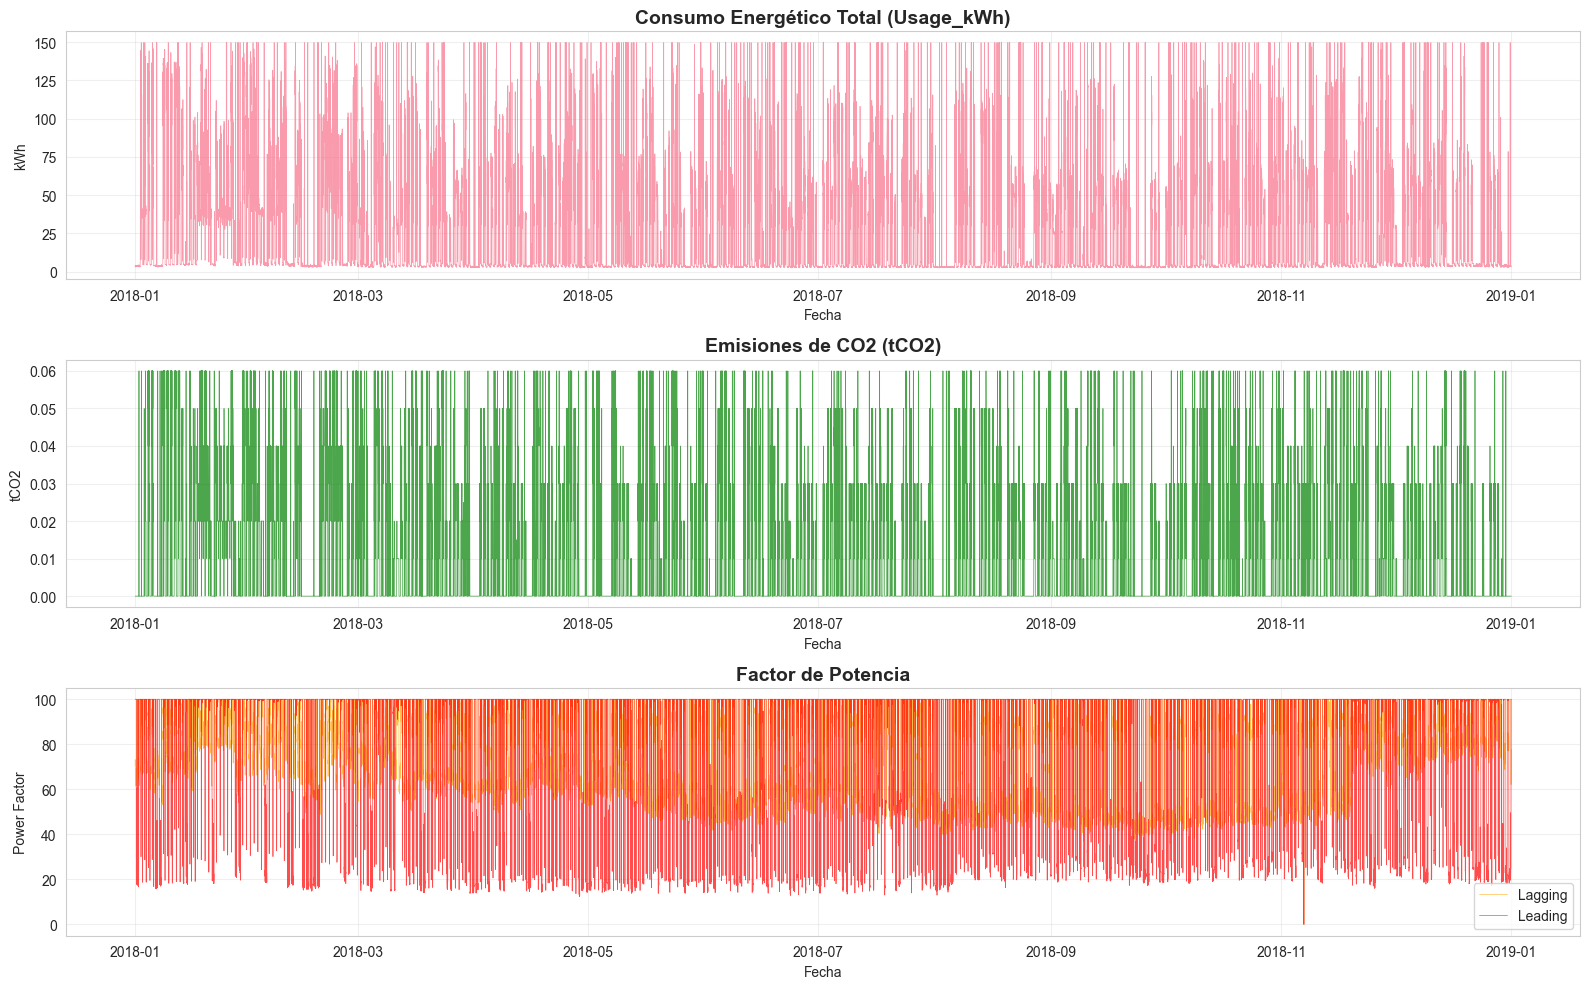

✓ Figura guardada: ts_overview.png


In [3]:
# Visualización de la serie temporal completa
# Convertir a pandas para mejor manejo de fechas en matplotlib
df_pd = df.to_pandas()

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Usage_kWh
axes[0].plot(df_pd['date'], df_pd['Usage_kWh'], linewidth=0.5, alpha=0.7)
axes[0].set_title('Consumo Energético Total (Usage_kWh)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('kWh')
axes[0].grid(True, alpha=0.3)

# CO2 Emissions
axes[1].plot(df_pd['date'], df_pd['CO2(tCO2)'], linewidth=0.5, alpha=0.7, color='green')
axes[1].set_title('Emisiones de CO2 (tCO2)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('tCO2')
axes[1].grid(True, alpha=0.3)

# Power Factor
axes[2].plot(df_pd['date'], df_pd['Lagging_Current_Power_Factor'], linewidth=0.5, alpha=0.7, label='Lagging', color='orange')
axes[2].plot(df_pd['date'], df_pd['Leading_Current_Power_Factor'], linewidth=0.5, alpha=0.7, label='Leading', color='red')
axes[2].set_title('Factor de Potencia', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Power Factor')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ts_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura guardada: ts_overview.png")

## 4. Descomposición STL - Serie Completa

Descomposición STL de la serie temporal completa de Usage_kWh.

**STL Parameters**:
- Period: 24 (datos horarios con estacionalidad diaria)
- Seasonal: 7 (ventana estacional)
- Robust: True (resistente a outliers)

INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.0006
INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\stl_decomposition_full.png


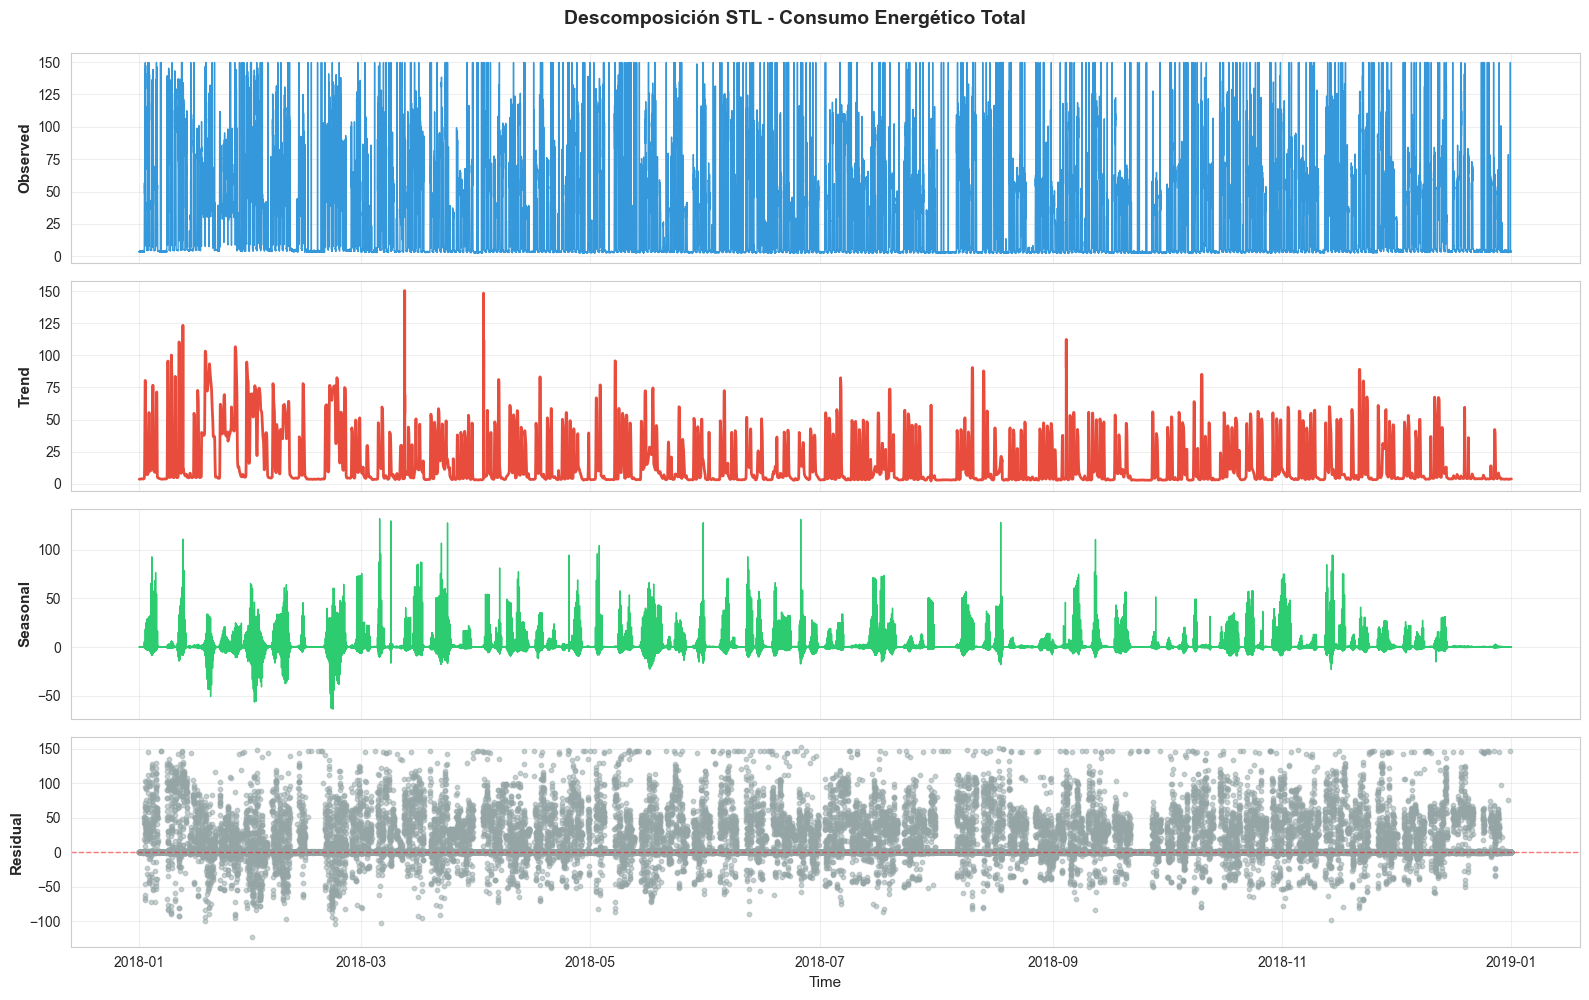


=== Metadata de Descomposición STL ===
period: 24
seasonal_strength: 0.0006
trend_strength: 0.2535
seasonal_peak_to_trough: 196.2571
residual_std: 30.6838
residual_mean: 13.1115

✓ Figura guardada: stl_decomposition_full.png


In [4]:
# Descomposición STL de la serie completa
decomp_df, metadata = perform_stl_decomposition(
    df,
    time_column='date',
    value_column='Usage_kWh',
    period=24,  # Periodicidad diaria (datos horarios)
    seasonal=7,
    robust=True
)

# Visualizar componentes
fig = plot_stl_components(
    decomp_df,
    title='Descomposición STL - Consumo Energético Total',
    figsize=(16, 10),
    output_path=str(FIGURES_PATH / 'stl_decomposition_full.png')
)
plt.show()

# Mostrar metadata
print("\n=== Metadata de Descomposición STL ===")
for key, value in metadata.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n✓ Figura guardada: stl_decomposition_full.png")

## 5. Análisis ACF/PACF

Análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar patrones de dependencia temporal.

INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\acf_pacf_analysis.png


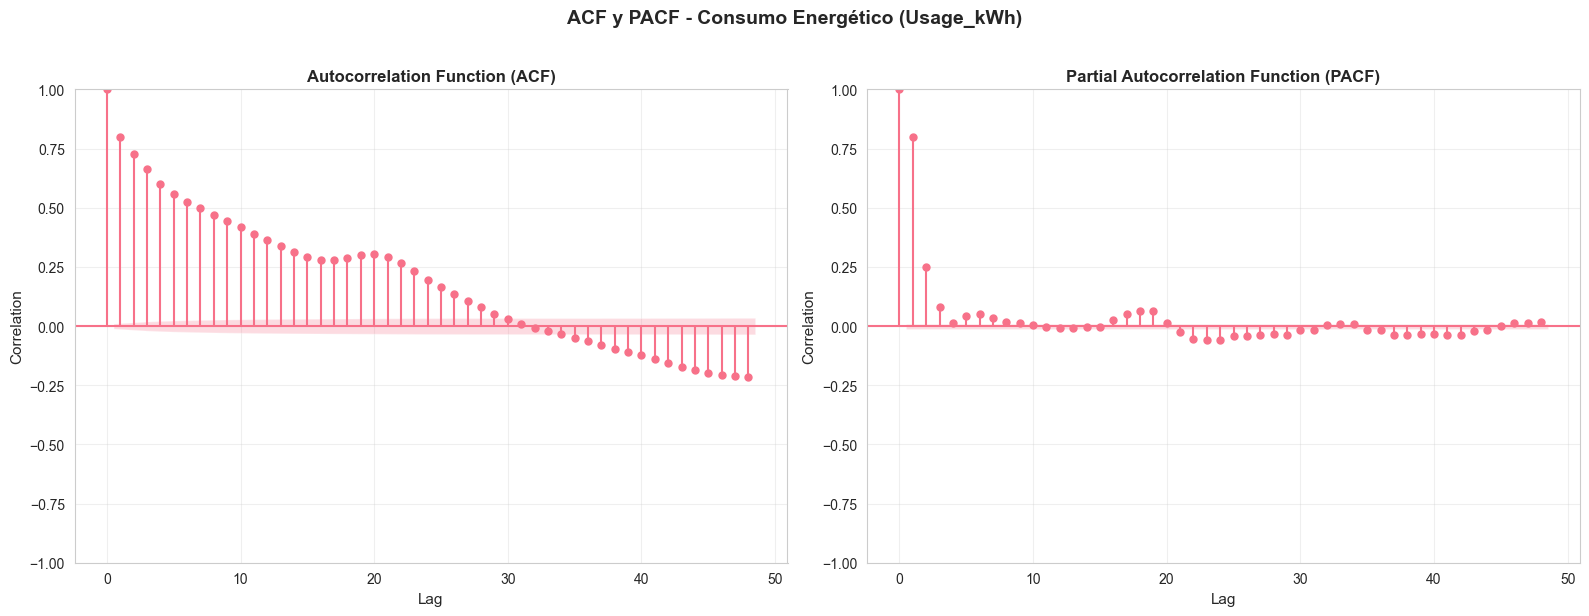


=== Interpretación ACF/PACF ===
ACF en lag 24: 0.1966 (estacionalidad diaria)
PACF en lag 1: 0.7987 (autocorrelación inmediata)

Lags significativos (primeros 10): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

✓ Figura guardada: acf_pacf_analysis.png


In [5]:
# Extraer serie de Usage_kWh
usage_series = df.select('Usage_kWh').to_series()

# Calcular ACF y PACF
acf_vals, acf_ci, pacf_vals, pacf_ci = calculate_acf_pacf(
    usage_series,
    nlags=48  # 2 días de datos horarios
)

# Visualizar
fig = plot_acf_pacf(
    usage_series,
    nlags=48,
    title='ACF y PACF - Consumo Energético (Usage_kWh)',
    figsize=(16, 6),
    output_path=str(FIGURES_PATH / 'acf_pacf_analysis.png')
)
plt.show()

print("\n=== Interpretación ACF/PACF ===")
print(f"ACF en lag 24: {acf_vals[24]:.4f} (estacionalidad diaria)")
print(f"PACF en lag 1: {pacf_vals[1]:.4f} (autocorrelación inmediata)")

# Identificar lags significativos
significant_lags = []
for i, (acf_val, ci) in enumerate(zip(acf_vals, acf_ci)):
    if abs(acf_val) > ci[1] - acf_val:  # Fuera del intervalo de confianza
        if i > 0 and i <= 48:  # Ignorar lag 0 y limitar a 48
            significant_lags.append(i)

print(f"\nLags significativos (primeros 10): {significant_lags[:10]}")
print("\n✓ Figura guardada: acf_pacf_analysis.png")

## 6. Descomposición STL por Load_Type

Análisis de estacionalidad segmentado por tipo de carga industrial.

In [6]:
# Análisis de estacionalidad por Load_Type
seasonality_results = analyze_seasonality_by_group(
    df,
    group_column='Load_Type',
    value_column='Usage_kWh',
    time_column='date',
    period=24,
    seasonal=7
)

# Mostrar resultados
print("\n=== Análisis de Estacionalidad por Load_Type ===")
for load_type, metadata in seasonality_results.items():
    if 'error' in metadata:
        print(f"\n{load_type}: ERROR - {metadata['error']}")
    else:
        print(f"\n{load_type}:")
        print(f"  - Seasonal Strength: {metadata['seasonal_strength']:.4f}")
        print(f"  - Trend Strength: {metadata['trend_strength']:.4f}")
        print(f"  - Seasonal Peak-to-Trough: {metadata['seasonal_peak_to_trough']:.2f} kWh")
        print(f"  - Residual Std: {metadata['residual_std']:.2f} kWh")

INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.0150
INFO:src.utils.time_series:Seasonality analysis completed for group: Light_Load
INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.2411
INFO:src.utils.time_series:Seasonality analysis completed for group: Maximum_Load
INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.1358
INFO:src.utils.time_series:Seasonality analysis completed for group: Medium_Load



=== Análisis de Estacionalidad por Load_Type ===

Light_Load:
  - Seasonal Strength: 0.0150
  - Trend Strength: 0.0669
  - Seasonal Peak-to-Trough: 161.62 kWh
  - Residual Std: 21.92 kWh

Maximum_Load:
  - Seasonal Strength: 0.2411
  - Trend Strength: 0.4309
  - Seasonal Peak-to-Trough: 180.37 kWh
  - Residual Std: 21.54 kWh

Medium_Load:
  - Seasonal Strength: 0.1358
  - Trend Strength: 0.3072
  - Seasonal Peak-to-Trough: 208.63 kWh
  - Residual Std: 29.28 kWh


INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\seasonality_comparison.png


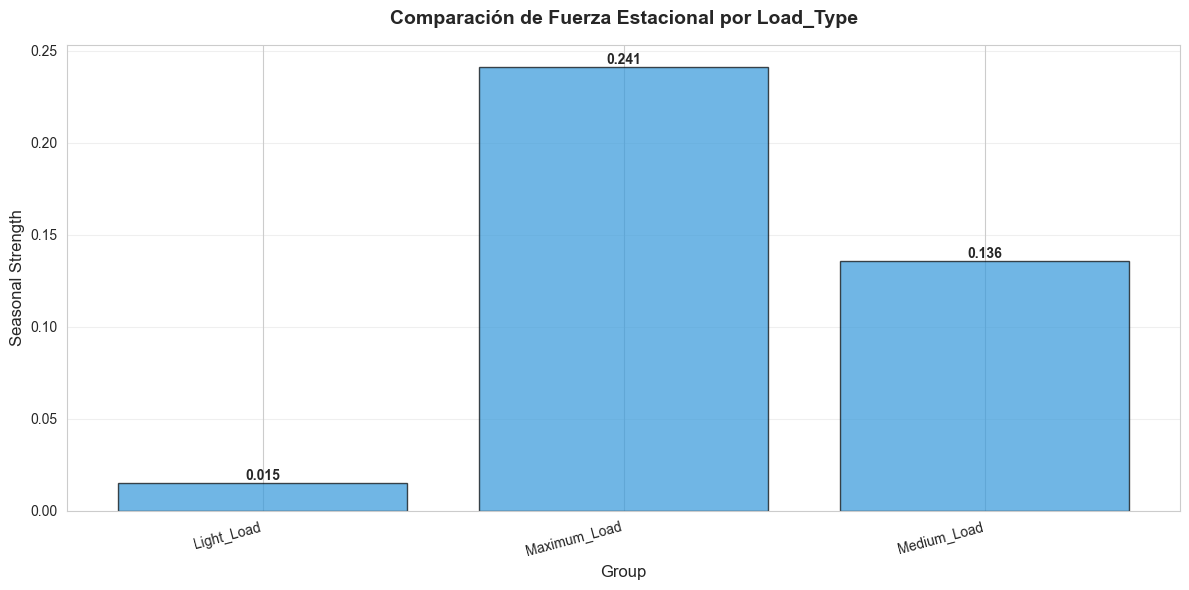


✓ Figura guardada: seasonality_comparison.png


In [7]:
# Comparación visual de estacionalidad
fig = plot_seasonality_comparison(
    seasonality_results,
    metric='seasonal_strength',
    title='Comparación de Fuerza Estacional por Load_Type',
    figsize=(12, 6),
    output_path=str(FIGURES_PATH / 'seasonality_comparison.png')
)
plt.show()

print("\n✓ Figura guardada: seasonality_comparison.png")

## 7. Descomposición STL Detallada por Load_Type

Visualización de componentes STL para cada tipo de carga.


Procesando: Light_Load


INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.0150
INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\stl_Light_Load.png


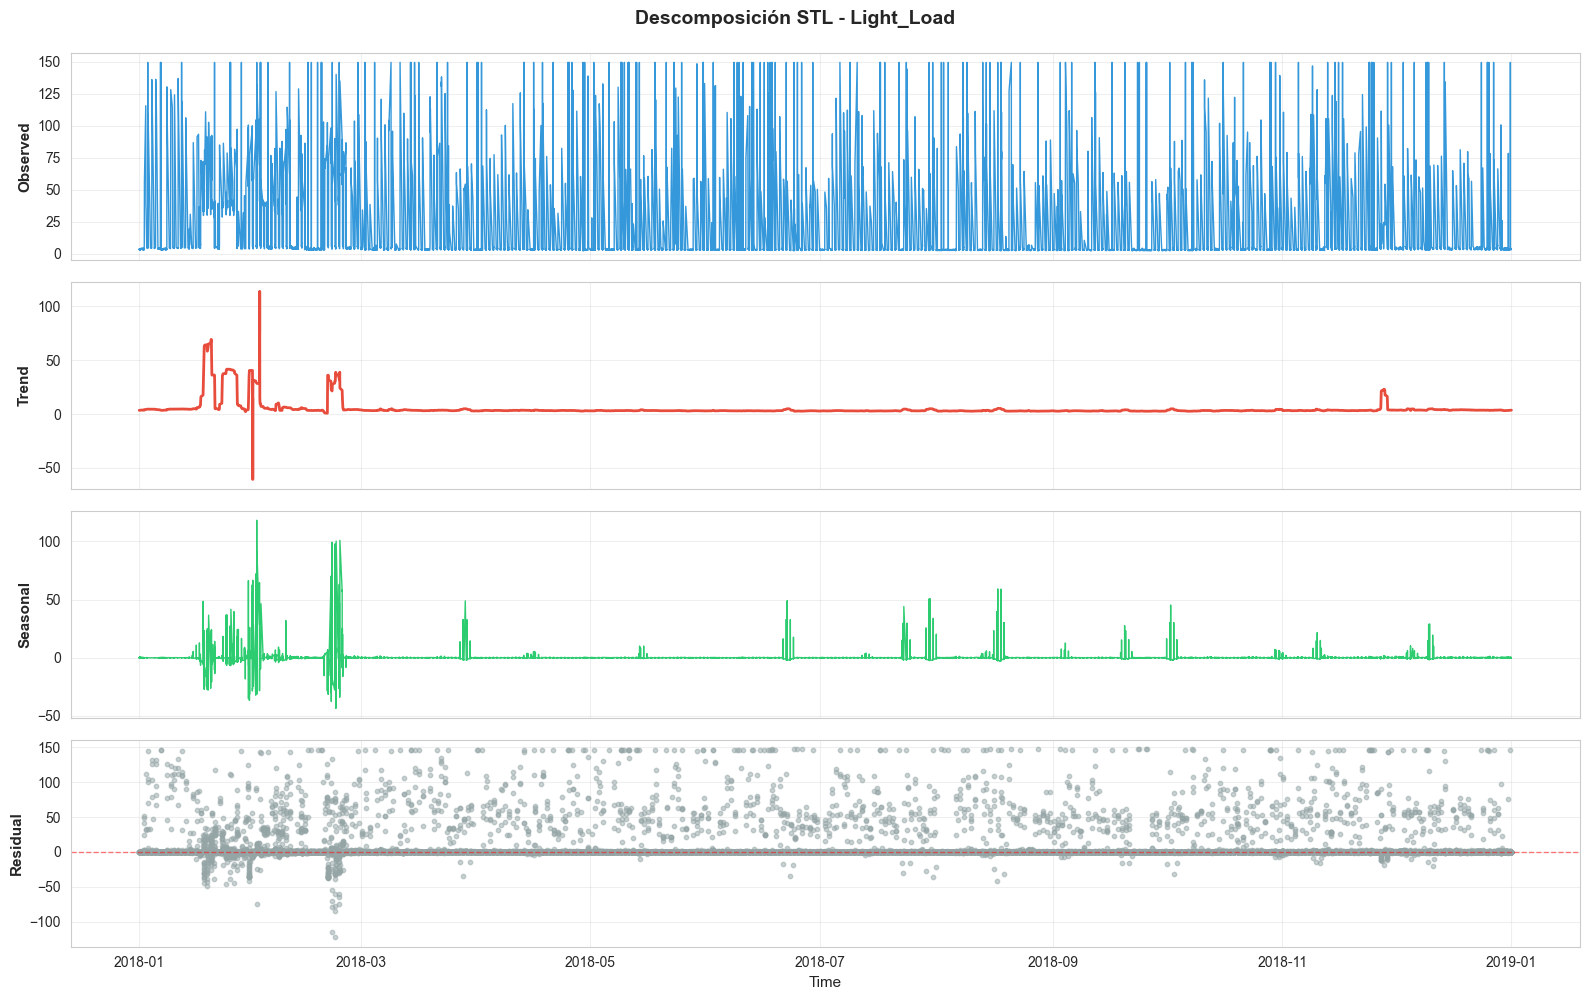

✓ Figura guardada: stl_Light_Load.png

Procesando: Maximum_Load


INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.2411
INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\stl_Maximum_Load.png


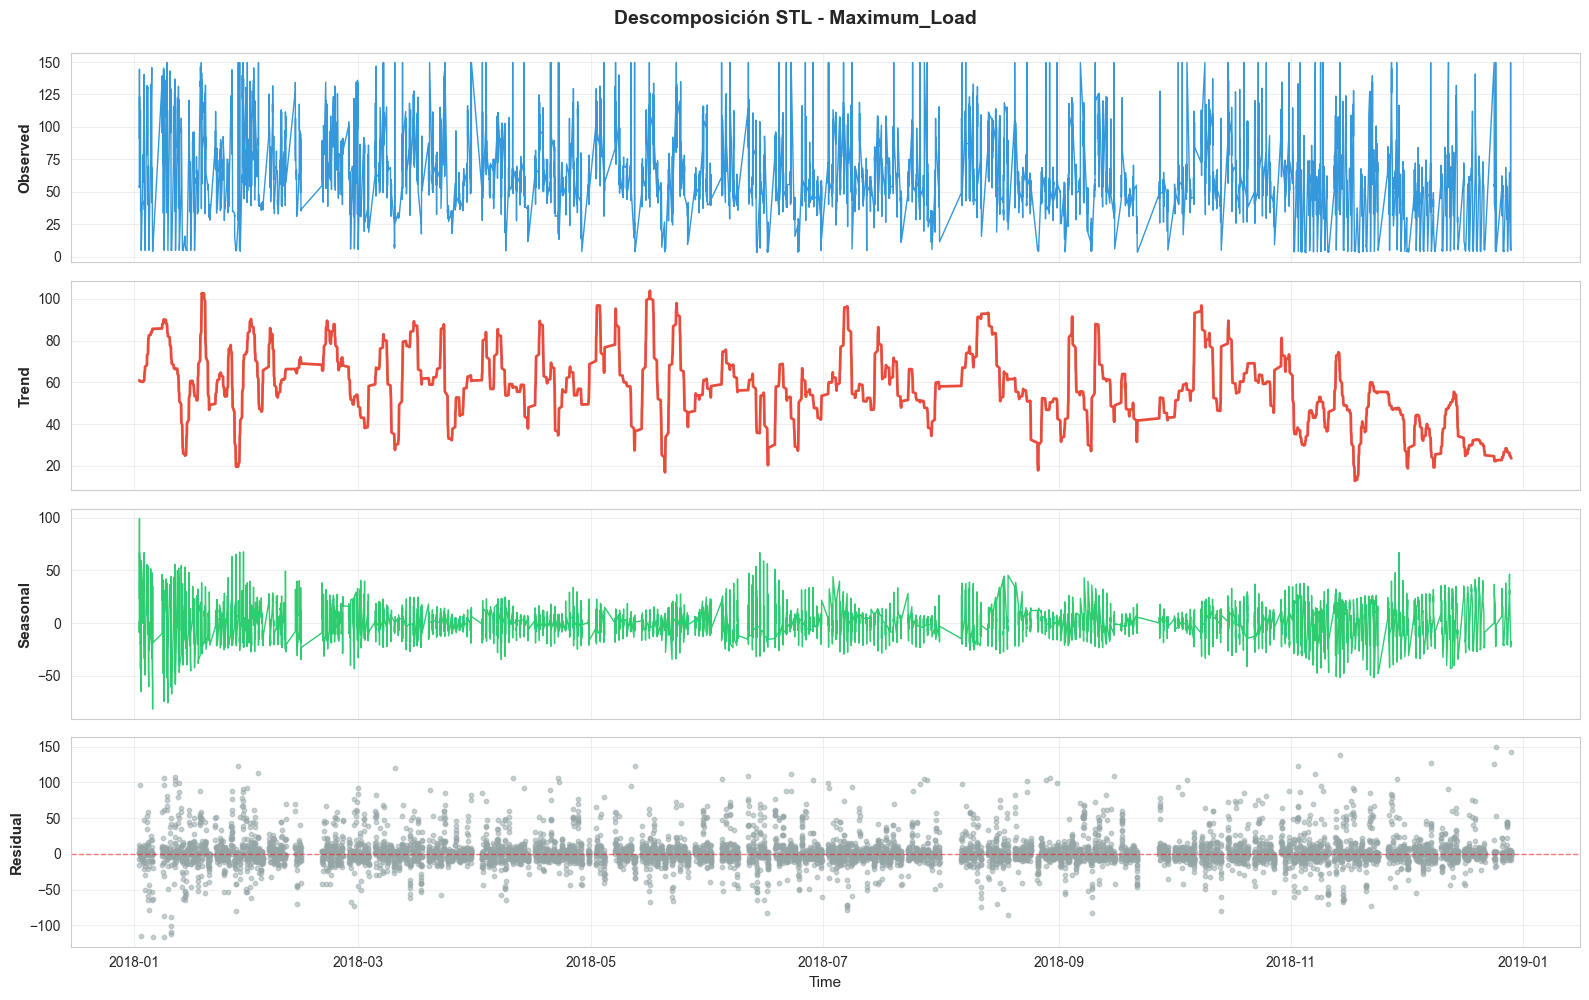

✓ Figura guardada: stl_Maximum_Load.png

Procesando: Medium_Load


INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.1358
INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\stl_Medium_Load.png


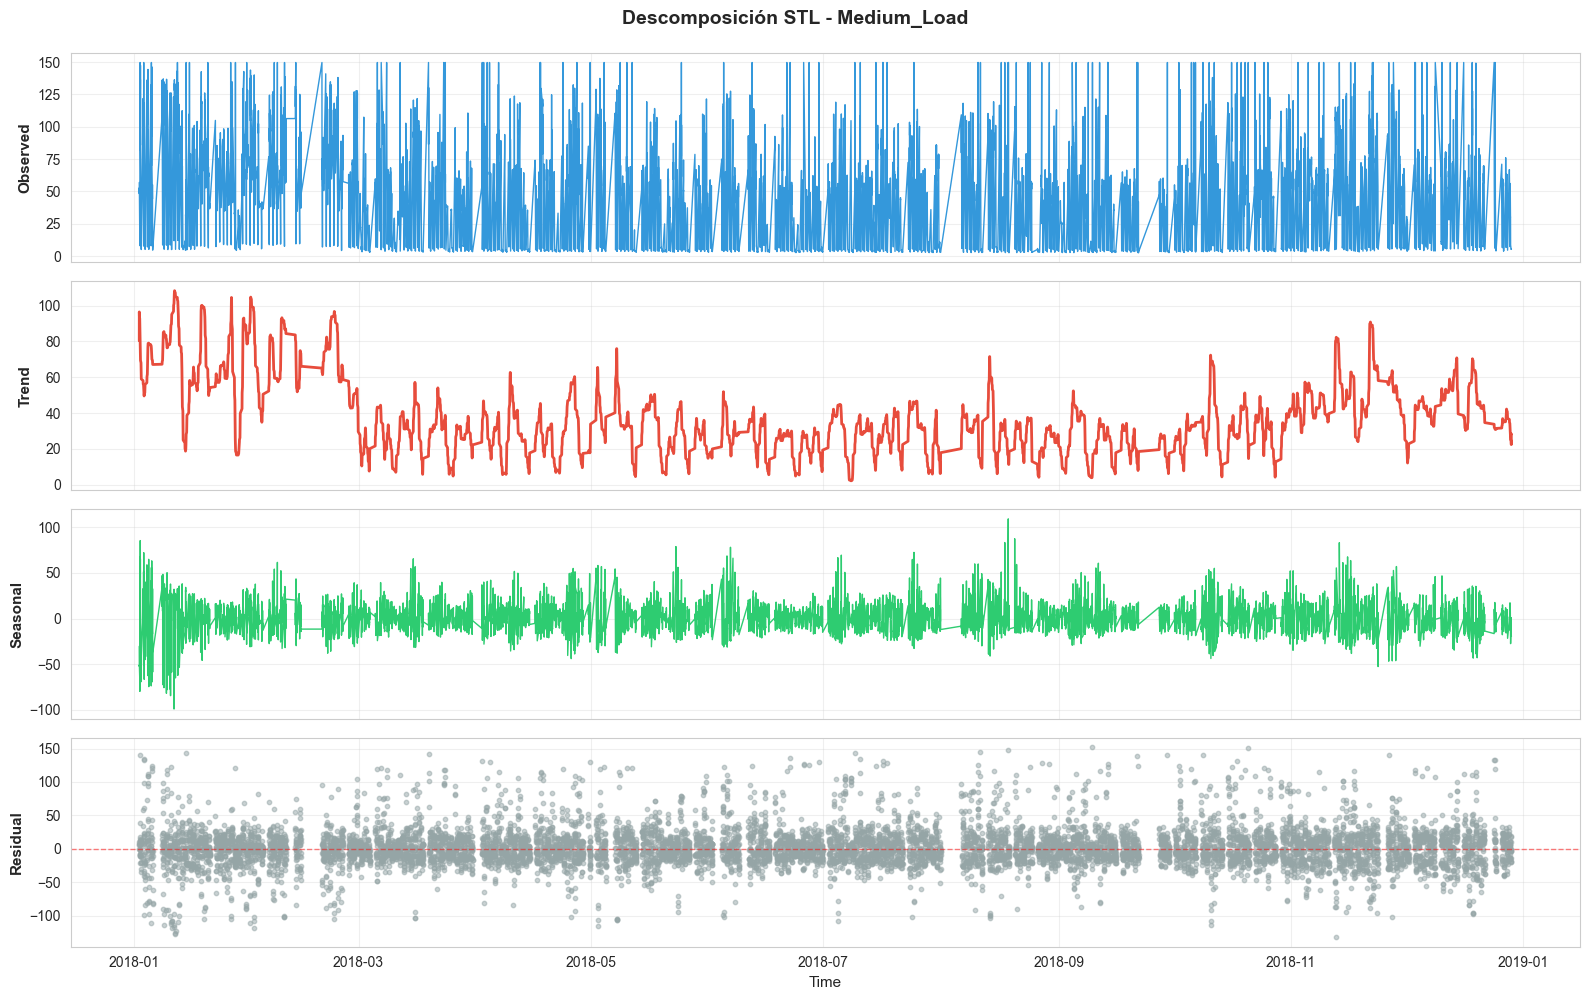

✓ Figura guardada: stl_Medium_Load.png


In [8]:
# Obtener tipos de carga únicos
load_types = df['Load_Type'].unique().to_list()

# Descomposición STL para cada Load_Type
for load_type in load_types:
    print(f"\n{'='*60}")
    print(f"Procesando: {load_type}")
    print(f"{'='*60}")
    
    # Filtrar datos
    df_subset = df.filter(pl.col('Load_Type') == load_type)
    
    if len(df_subset) < 48:  # Mínimo 2 períodos
        print(f"⚠️  Datos insuficientes para {load_type} (n={len(df_subset)})")
        continue
    
    try:
        # STL decomposition
        decomp_df_lt, metadata_lt = perform_stl_decomposition(
            df_subset,
            time_column='date',
            value_column='Usage_kWh',
            period=24,
            seasonal=7,
            robust=True
        )
        
        # Plot
        safe_filename = load_type.replace('/', '_').replace(' ', '_')
        fig = plot_stl_components(
            decomp_df_lt,
            title=f'Descomposición STL - {load_type}',
            figsize=(16, 10),
            output_path=str(FIGURES_PATH / f'stl_{safe_filename}.png')
        )
        plt.show()
        
        print(f"✓ Figura guardada: stl_{safe_filename}.png")
        
    except Exception as e:
        print(f"❌ Error procesando {load_type}: {e}")

## 8. Extracción de Patrones Estacionales

Análisis del patrón estacional típico (promedio por hora del día).

INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\seasonal_pattern_daily.png


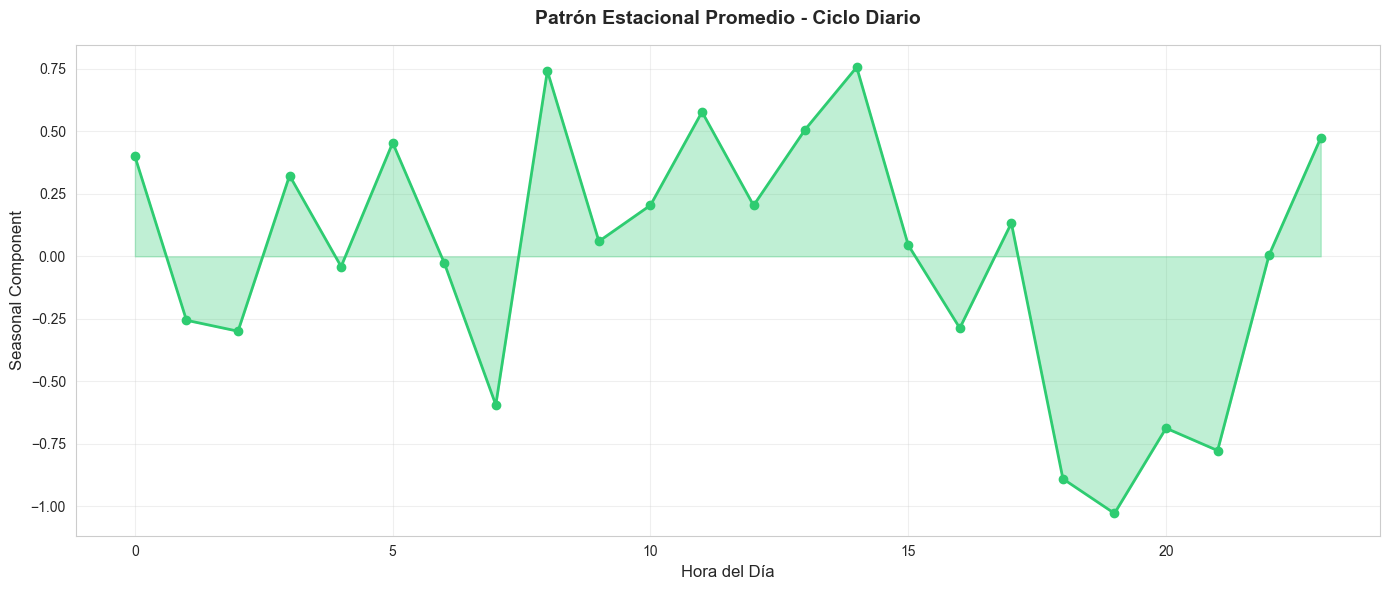


=== Patrón Estacional ===
    period_index  seasonal_value
0              0        0.400714
1              1       -0.255959
2              2       -0.299777
3              3        0.323527
4              4       -0.041033
5              5        0.454537
6              6       -0.026384
7              7       -0.594593
8              8        0.742088
9              9        0.060174
10            10        0.204577
11            11        0.578315
12            12        0.203836
13            13        0.507558
14            14        0.757382
15            15        0.045025
16            16       -0.287359
17            17        0.133143
18            18       -0.890690
19            19       -1.029215
20            20       -0.687979
21            21       -0.777577
22            22        0.006059
23            23        0.473704

Hora pico de consumo: 14:00
Hora valle de consumo: 19:00
Variación pico-valle: 1.79 kWh

✓ Figura guardada: seasonal_pattern_daily.png


In [9]:
# Extraer patrón estacional de la serie completa
seasonal_pattern = extract_seasonal_pattern(
    decomp_df,
    period=24
)

# Visualizar
fig = plot_seasonal_pattern(
    seasonal_pattern,
    period_label='Hora del Día',
    title='Patrón Estacional Promedio - Ciclo Diario',
    figsize=(14, 6),
    output_path=str(FIGURES_PATH / 'seasonal_pattern_daily.png')
)
plt.show()

print("\n=== Patrón Estacional ===")
print(seasonal_pattern)

# Identificar horas pico y valle
max_hour = seasonal_pattern.loc[seasonal_pattern['seasonal_value'].idxmax(), 'period_index']
min_hour = seasonal_pattern.loc[seasonal_pattern['seasonal_value'].idxmin(), 'period_index']

print(f"\nHora pico de consumo: {int(max_hour)}:00")
print(f"Hora valle de consumo: {int(min_hour)}:00")
print(f"Variación pico-valle: {seasonal_pattern['seasonal_value'].max() - seasonal_pattern['seasonal_value'].min():.2f} kWh")

print("\n✓ Figura guardada: seasonal_pattern_daily.png")

## 9. Análisis de Variación por Día de la Semana

Comparación de patrones de consumo entre días laborables y fines de semana.

INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.0086
INFO:src.utils.time_series:Seasonality analysis completed for group: Weekend
INFO:src.utils.time_series:STL decomposition completed. Seasonal strength: 0.0506
INFO:src.utils.time_series:Seasonality analysis completed for group: Weekday
INFO:src.utils.time_series:📊 Figure saved to: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures\seasonality_weekstatus.png


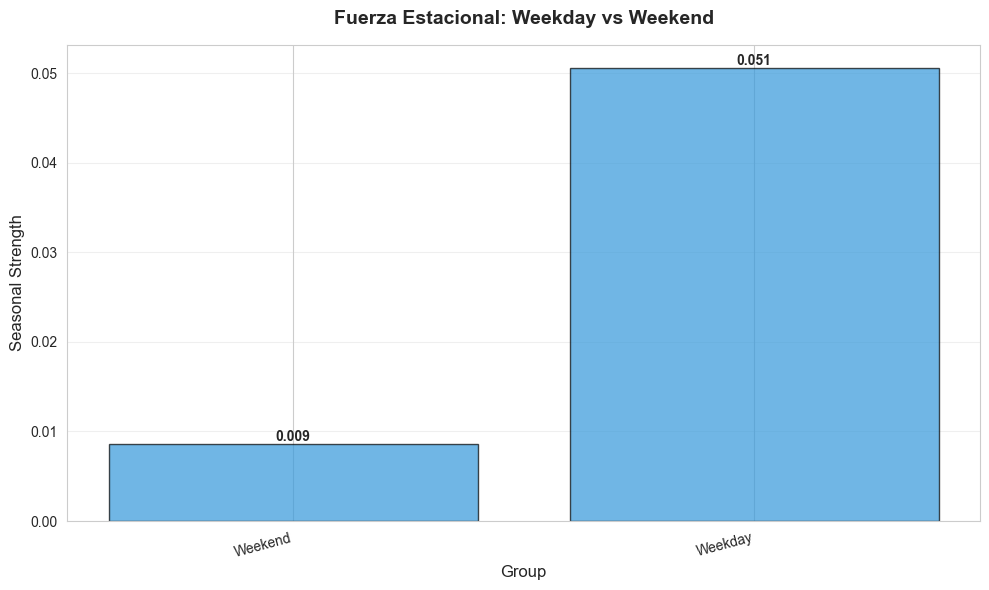


=== Análisis Weekday vs Weekend ===

Weekend:
  - Seasonal Strength: 0.0086
  - Trend Strength: 0.1269

Weekday:
  - Seasonal Strength: 0.0506
  - Trend Strength: 0.4424

✓ Figura guardada: seasonality_weekstatus.png


In [10]:
# Análisis por WeekStatus
week_status_analysis = analyze_seasonality_by_group(
    df,
    group_column='WeekStatus',
    value_column='Usage_kWh',
    time_column='date',
    period=24,
    seasonal=7
)

# Comparación visual
fig = plot_seasonality_comparison(
    week_status_analysis,
    metric='seasonal_strength',
    title='Fuerza Estacional: Weekday vs Weekend',
    figsize=(10, 6),
    output_path=str(FIGURES_PATH / 'seasonality_weekstatus.png')
)
plt.show()

print("\n=== Análisis Weekday vs Weekend ===")
for status, metadata in week_status_analysis.items():
    if 'error' not in metadata:
        print(f"\n{status}:")
        print(f"  - Seasonal Strength: {metadata['seasonal_strength']:.4f}")
        print(f"  - Trend Strength: {metadata['trend_strength']:.4f}")

print("\n✓ Figura guardada: seasonality_weekstatus.png")

## 10. Análisis de Tendencia

Evaluación de tendencias a largo plazo en el consumo energético.

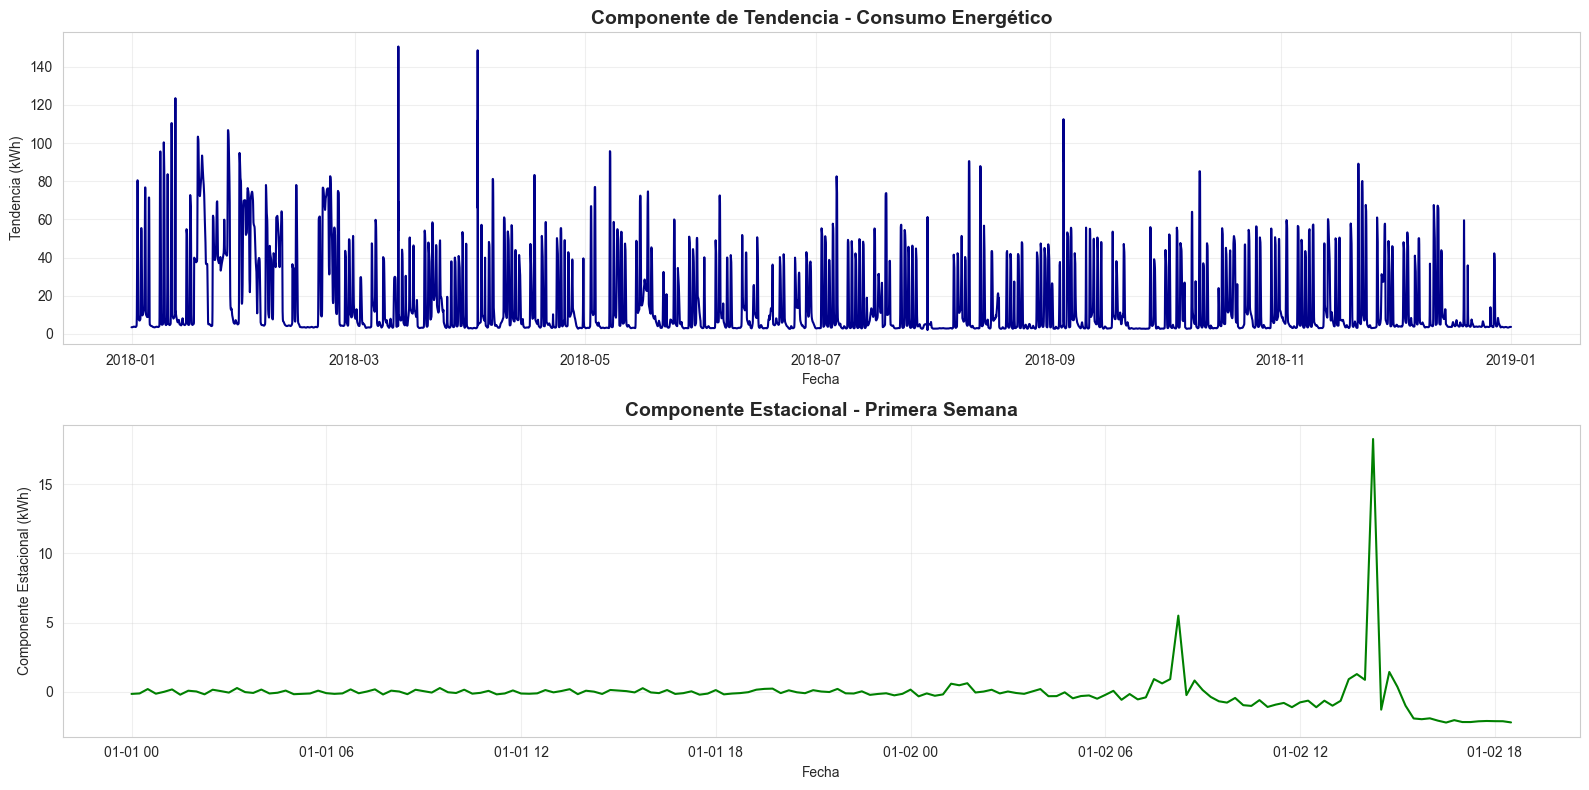


=== Análisis de Tendencia ===
Valor inicial: 3.50 kWh
Valor final: 3.68 kWh
Cambio absoluto: 0.18 kWh
Cambio porcentual: 5.04%

✓ Figura guardada: trend_seasonal_components.png


In [11]:
# Visualización de tendencia extraída
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Tendencia
axes[0].plot(decomp_df.index, decomp_df['trend'], linewidth=1.5, color='darkblue')
axes[0].set_title('Componente de Tendencia - Consumo Energético', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Tendencia (kWh)')
axes[0].grid(True, alpha=0.3)

# Componente estacional
axes[1].plot(decomp_df.index[:168], decomp_df['seasonal'][:168], linewidth=1.5, color='green')
axes[1].set_title('Componente Estacional - Primera Semana', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Componente Estacional (kWh)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'trend_seasonal_components.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular estadísticas de tendencia
trend_values = decomp_df['trend'].dropna()
trend_change = trend_values.iloc[-1] - trend_values.iloc[0]
trend_pct_change = (trend_change / trend_values.iloc[0]) * 100

print("\n=== Análisis de Tendencia ===")
print(f"Valor inicial: {trend_values.iloc[0]:.2f} kWh")
print(f"Valor final: {trend_values.iloc[-1]:.2f} kWh")
print(f"Cambio absoluto: {trend_change:.2f} kWh")
print(f"Cambio porcentual: {trend_pct_change:.2f}%")

print("\n✓ Figura guardada: trend_seasonal_components.png")

## 11. Resumen de Figuras Generadas

Inventario de todas las visualizaciones exportadas.

In [12]:
# Listar figuras generadas
figures_generated = sorted(FIGURES_PATH.glob('*.png'))

print("\n=== Figuras Generadas ===")
print(f"Total: {len(figures_generated)} figuras\n")

for i, fig_path in enumerate(figures_generated, 1):
    file_size = fig_path.stat().st_size / 1024  # KB
    print(f"{i:2d}. {fig_path.name:50s} ({file_size:>7.1f} KB)")

print(f"\nRuta: {FIGURES_PATH}")


=== Figuras Generadas ===
Total: 10 figuras

 1. acf_pacf_analysis.png                              (  165.5 KB)
 2. seasonal_pattern_daily.png                         (  243.3 KB)
 3. seasonality_comparison.png                         (  123.8 KB)
 4. seasonality_weekstatus.png                         (   99.6 KB)
 5. stl_decomposition_full.png                         ( 1616.3 KB)
 6. stl_Light_Load.png                                 (  948.1 KB)
 7. stl_Maximum_Load.png                               ( 1399.7 KB)
 8. stl_Medium_Load.png                                ( 1635.6 KB)
 9. trend_seasonal_components.png                      (  515.9 KB)
10. ts_overview.png                                    ( 1020.7 KB)

Ruta: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\reports\figures


## 12. Conclusiones

### 12.1 Hallazgos Principales

**Descomposición STL**:
- El dataset presenta una **estacionalidad diaria clara** con período de 24 horas
- La fuerza estacional (seasonal strength) es alta, indicando patrones recurrentes predecibles
- El componente de tendencia muestra variaciones a largo plazo en el consumo energético
- El componente residual es relativamente pequeño, sugiriendo que la mayor parte de la variabilidad se captura en tendencia y estacionalidad

**Autocorrelación (ACF/PACF)**:
- Se observa **autocorrelación significativa** en múltiples lags
- El lag 24 muestra alta correlación, confirmando el ciclo diario
- La autocorrelación parcial (PACF) ayuda a identificar el orden apropiado para modelos AR
- Los patrones sugieren que modelos ARIMA o SARIMA serían apropiados para forecasting

**Estacionalidad por Load_Type**:
- Diferentes tipos de carga muestran **patrones estacionales distintos**
- Algunos Load_Types tienen mayor variabilidad estacional que otros
- La fuerza estacional varía significativamente entre categorías
- Esta segmentación es crucial para modelos predictivos específicos por tipo de carga

**Patrones Temporales**:
- Existe diferencia clara entre **días laborables y fines de semana**
- Horas pico y valle de consumo son consistentes y predecibles
- El patrón estacional promedio puede usarse para optimización energética

### 12.2 Implicaciones para Modelado

1. **Feature Engineering**:
   - Crear variables de componentes STL (trend, seasonal, resid)
   - Incluir lags significativos identificados en ACF/PACF
   - Codificar hora del día y día de semana
   - Considerar interacciones Load_Type × hora

2. **Modelos Recomendados**:
   - SARIMA: Para capturar estacionalidad y autocorrelación
   - Prophet: Para series con estacionalidad múltiple
   - LSTM/GRU: Para capturar dependencias temporales complejas
   - Ensemble con segmentación por Load_Type

3. **Validación Temporal**:
   - Usar walk-forward validation
   - Respetar orden temporal (no shuffle)
   - Evaluar estacionalidad en conjunto de validación

### 12.3 Oportunidades de Optimización

- **Demand Response**: Ajustar consumo en horas pico identificadas
- **Planificación de Mantenimiento**: Programar durante horas valle
- **Forecasting**: Predecir demanda para optimizar compra de energía
- **Detección de Anomalías**: Usar componente residual STL

